In [9]:
using NBInclude
@nbinclude("functions.ipynb")


All function imported


In [10]:
#setup a synthetic problem
k = 20
n1 = 100
x_dim = 400
m = 120
trials = 20
tolerance = 1e-7; max_iter = 2000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1) # optimizer

A = sample_fourier(n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination
W1 = randn(n1, 20)/sqrt(n1) #random inner layer weight matrix

F = dct(diagm(ones(x_dim)),2);
z = randn(k) # ground code vector
β_list, α_list = get_β_α(F, A, B, 11);

In [11]:
recovery_error_matrix = zeros(trials)
recon_error_matrix = zeros(trials)
for β in β_list
    recovery_error_list = []
    recon_error_list = []
    G = Chain(
        Dense(20, n1, relu, bias = false; init =(out,in) -> W1),
        Dense(n1, x_dim, identity, bias = false; init =(out,in) -> β*A + (1-β) * B)
    )    #setup the generative network 

    for trials in 1:trials
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
end

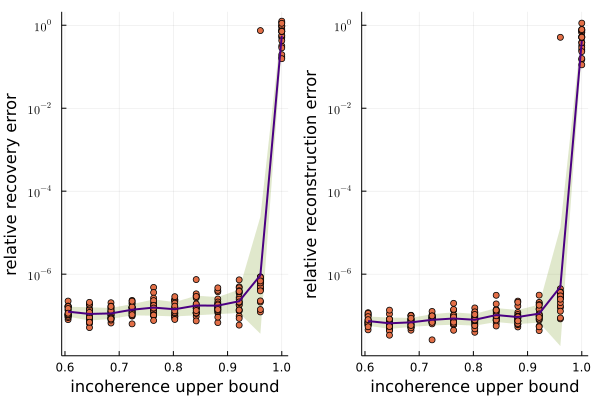

In [14]:
log_recovery_error_matrix = log10.(recovery_error_matrix[:, 2:end])
average_recov = mean(log_recovery_error_matrix, dims=1)'
std_recov = std(log_recovery_error_matrix, dims=1)'
plot(α_list, average_recov + std_recov, fillrange =  average_recov - std_recov, fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recovery_error_matrix[:], label =:false)
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false)
yticks = [-6:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])



log_recon_error_matrix = log10.(recon_error_matrix[:, 2:end])
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(α_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false)
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )
yticks = [-6:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])
plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))

In [15]:
savefig("figures/Random_GNN_error.pdf")
save("saved_data/Random_GNN_error.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)
